In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install catboost

# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [55]:
# import library

# data habdling library
import pandas as pd
import numpy as np
import random
from collections import Counter
from scipy import stats
from scipy.stats import randint, uniform

# machine learning library
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression, f_classif, SelectKBest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
# xgboost
import xgboost
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb # LGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier
# eli5
import eli5
from eli5.sklearn import PermutationImportance
# PDP
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
# SHAP
import shap

# 시각화 library
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc
# font 적용
plt.rc('font', family = 'NanumBarunGothic')
# 레티나 설정 : 글자가 흐릿하게 보이는 현상 방지
%config InlineBackend.figure_format = 'retina'
# ggplot 으로 그래프 스타일 설정
plt.style.use('ggplot')
# 마이너스폰트 설정
plt.rc('axes', unicode_minus=False)
# warning 방지
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

1. 데이터 선정 이유 및 문제 정의  
데이터를 선정할 때에는 반드시 왜 해당 데이터를 선택했는지에 대해 유병욱님의 이유를 자세히 설명해주셔야 합니다. 데이터셋 선정이 끝났다면 어떤 유형의 문제로 (분류 / 회귀) 접근할지도 결정합니다.

2. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택  
데이터를 선정함과 동시에 데이터를 통해서 내가 무엇을 해볼 수 있을지 가설을 세우는 것이 중요합니다. 가설은 쓸모 있어야 한다는 사실을 잊지마시길 바랍니다.
데이터 기반의 사고방식, data-driven의 마음가짐을 section1과 2에서 배웠습니다. 이번에는 그것들을 심화시켜서 문제 해결을 시도 해봅니다.

    * 태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.  
        * 해당 특성을 target으로 지정한 이유를 설명하세요.
        * 해당 모델과 평가지표를 선택한 이유를 설명하세요.

3. EDA와 데이터 전처리  
가설을 정했고 베이스라인을 만들었다면 데이터의 탐색 및 가공을 시작해봅니다. 바로 적용이 될 수 있는 데이터도 있겠지만, 대부분의 데이터는 전처리 작업이 필요합니다.
데이터 전처리를 통해 할 수 있는 것은 다양하지만 다음을 시도해볼 수 있습니다.

    * EDA  
    * Feature Engineering  
    * 데이터의 정규화  
    * 노이즈 제거  
    * 결측치 제거 혹은 대체  
    * 데이터 밸런스  
    * 그 외  
        * 태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.  
        * Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?

**유병욱님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?**

4. 머신러닝 방식 적용 및 교차검증  
데이터의 탐색과 전처리 작업이 끝났다면 모델링을 통해 베이스라인과의 성능 비교를 해봅니다.

    * Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)  
    * 평가지표를 계산 후 베이스라인과 비교해보세요.  
    * 어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.  
    * 모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.  
        * Hyperparameter tuning, etc.  
    * 최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.  
    * 최종 모델의 test 점수를 보고하세요.  
    * 태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.  
        * 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?  
        * 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?  

    * 최종 모델에 관해 설명하세요.  

5. 머신러닝 모델 해석  
프로젝트에서 가장 중요하다고 볼 수 있는 부분 입니다. 우리는 SHAP, PDP 등을 통해서 모델이 관측치를 어떤 특성을 활용했거나, 어떤 특성이 타겟에 영향을 끼쳤는지 등을 해석하는 방법에 대해서 배웠습니다.
여러분의 프로젝트에도 이러한 해석 방법을 활용해 머신러닝 모델을 비전문가라도 조금 더 쉽게 이해하고 접근할 수 있도록 해주셔야 합니다.

    * PDP, SHAP을 활용하여 최종 모델을 설명합니다
    * 시각화는 "설명"이 제일 중요합니다.
    * 태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.
    * 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
    * 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?


### 저는 코드스테이츠의 기업신용평가팀의 유병욱 입니다.
* 코로나로 인해 많은 회사들이 파산을 당하고 있습니다.  
![기업파산](https://newsimg.sedaily.com/2020/11/12/1ZADNFFI5Q_10.gif)
![지방기업파산](https://newsimg.sedaily.com/2020/11/18/1ZAGDB4IB0_4.jpg)
* 1999년 부터 2009년 까지 부도를 맞게된 기업들의 각종 특성들을 살펴보며 저희가 평가하게 될 다른 기업들의 이상징후가 나타날때 그 기업에게 권고 또는 통보를 해주기 위해서 혹은 더 많은 전체데이터를 가지고 분석을 해야할지에 대한 고찰을 위해 이 데이터를 분석하게 되었습니다.  
* 파산을 하게 될지 아닐지에 대한 분석이기 때문에 분류문제로 접근하겠습니다.

### Column names and Description 

* Y - Bankrupt?: Target label (0 = Financailly Stable, 1 = Financailly Unstable)   
* X1 - ROA(C) before interest and depreciation before interest: Return On Total * Assets(C)  
* X2 - ROA(A) before interest and % after tax: Return On Total Assets(A)  
* X3 - ROA(B) before interest and depreciation after tax: Return On Total Assets(B)  
* X4 - Operating Gross Margin: Gross Profit/Net Sales  
* X5 - Realized Sales Gross Margin: Realized Gross Profit/Net Sales  
* X6 - Operating Profit Rate: Operating Income/Net Sales  
* X7 - Pre-tax net Interest Rate: Pre-Tax Income/Net Sales  
* X8 - After-tax net Interest Rate: Net Income/Net Sales  
* X9 - Non-industry income and expenditure/revenue: Net Non-operating Income Ratio  
* X10 - Continuous interest rate (after tax): Net Income-Exclude Disposal Gain or Loss/Net Sales  
* X11 - Operating Expense Rate: Operating Expenses/Net Sales  
* X12 - Research and development expense rate: (Research and Development Expenses)/Net Sales  
* X13 - Cash flow rate: Cash Flow from Operating/Current Liabilities  
* X14 - Interest-bearing debt interest rate: Interest-bearing Debt/Equity  
* X15 - Tax rate (A): Effective Tax Rate  
* X16 - Net Value Per Share (B): Book Value Per Share(B)  
* X17 - Net Value Per Share (A): Book Value Per Share(A)  
* X18 - Net Value Per Share (C): Book Value Per Share(C)  
* X19 - Persistent EPS in the Last Four Seasons: EPS-Net Income  
* X20 - Cash Flow Per Share  
* X21 - Revenue Per Share (Yuan ¥): Sales Per Share  
* X22 - Operating Profit Per Share (Yuan ¥): Operating Income Per Share  
* X23 - Per Share Net profit before tax (Yuan ¥): Pretax Income Per Share  
* X24 - Realized Sales Gross Profit Growth Rate  
* X25 - Operating Profit Growth Rate: Operating Income Growth  
* X26 - After-tax Net Profit Growth Rate: Net Income Growth  
* X27 - Regular Net Profit Growth Rate: Continuing Operating Income after Tax Growth  
* X28 - Continuous Net Profit Growth Rate: Net Income-Excluding Disposal Gain or Loss Growth  
* X29 - Total Asset Growth Rate: Total Asset Growth  
* X30 - Net Value Growth Rate: Total Equity Growth  
* X31 - Total Asset Return Growth Rate Ratio: Return on Total Asset Growth  
* X32 - Cash Reinvestment %: Cash Reinvestment Ratio  
* X33 - Current Ratio  
* X34 - Quick Ratio: Acid Test  
* X35 - Interest Expense Ratio: Interest Expenses/Total Revenue  
* X36 - Total debt/Total net worth: Total Liability/Equity Ratio  
* X37 - Debt ratio %: Liability/Total Assets  
* X38 - Net worth/Assets: Equity/Total Assets  
* X39 - Long-term fund suitability ratio (A): (Long-term Liability+Equity)/* Fixed Assets  
* X40 - Borrowing dependency: Cost of Interest-bearing Debt  
* X41 - Contingent liabilities/Net worth: Contingent Liability/Equity  
* X42 - Operating profit/Paid-in capital: Operating Income/Capital  
* X43 - Net profit before tax/Paid-in capital: Pretax Income/Capital  
* X44 - Inventory and accounts receivable/Net value: (Inventory+Accounts Receivables)/Equity  
* X45 - Total Asset Turnover  
* X46 - Accounts Receivable Turnover  
* X47 - Average Collection Days: Days Receivable Outstanding  
* X48 - Inventory Turnover Rate (times)  
* X49 - Fixed Assets Turnover Frequency  
* X50 - Net Worth Turnover Rate (times): Equity Turnover  
* X51 - Revenue per person: Sales Per Employee  
* X52 - Operating profit per person: Operation Income Per Employee  
* X53 - Allocation rate per person: Fixed Assets Per Employee  
* X54 - Working Capital to Total Assets  
* X55 - Quick Assets/Total Assets  
* X56 - Current Assets/Total Assets  
* X57 - Cash/Total Assets  
* X58 - Quick Assets/Current Liability  
* X59 - Cash/Current Liability  
* X60 - Current Liability to Assets  
* X61 - Operating Funds to Liability   
* X62 - Inventory/Working Capital  
* X63 - Inventory/Current Liability  
* X64 - Current Liabilities/Liability  
* X65 - Working Capital/Equity  
* X66 - Current Liabilities/Equity  
* X67 - Long-term Liability to Current Assets  
* X68 - Retained Earnings to Total Assets  
* X69 - Total income/Total expense  
* X70 - Total expense/Assets  
* X71 - Current Asset Turnover Rate: Current Assets to Sales  
* X72 - Quick Asset Turnover Rate: Quick Assets to Sales  
* X73 - Working capitcal Turnover Rate: Working Capital to Sales  
* X74 - Cash Turnover Rate: Cash to Sales  
* X75 - Cash Flow to Sales  
* X76 - Fixed Assets to Assets  
* X77 - Current Liability to Liability  
* X78 - Current Liability to Equity  
* X79 - Equity to Long-term Liability  
* X80 - Cash Flow to Total Assets  
* X81 - Cash Flow to Liability  
* X82 - CFO to Assets  
* X83 - Cash Flow to Equity  
* X84 - Current Liability to Current Assets  
* X85 - Liability-Assets Flag: 1 if Total Liability exceeds Total Assets, 0 otherwise  
* X86 - Net Income to Total Assets  
* X87 - Total assets to GNP price  
* X88 - No-credit Interval  
* X89 - Gross Profit to Sales  
* X90 - Net Income to Stockholder's Equity  
* X91 - Liability to Equity  
* X92 - Degree of Financial Leverage (DFL)  
* X93 - Interest Coverage Ratio (Interest expense to EBIT)  
* X94 - Net Income Flag: 1 if Net Income is Negative for the last two years, 0 otherwise  
* X95 - Equity to Liability  

# EDA

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Liam427/stuydy-data/main/data/Company%20Bankruptcy.csv')
print(df.shape)
df.head()

(6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

* 제가 분석하고자 하는 데이터는 target 특성인 Bankrupt? 과 95개의 특성을 가지고 있습니다.  
    * sample 은 6819 개가 있습니다. 
    * 모든 데이터는 숫자형 데이터입니다.  
    * 결측치는 없습니다.  

### target value

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


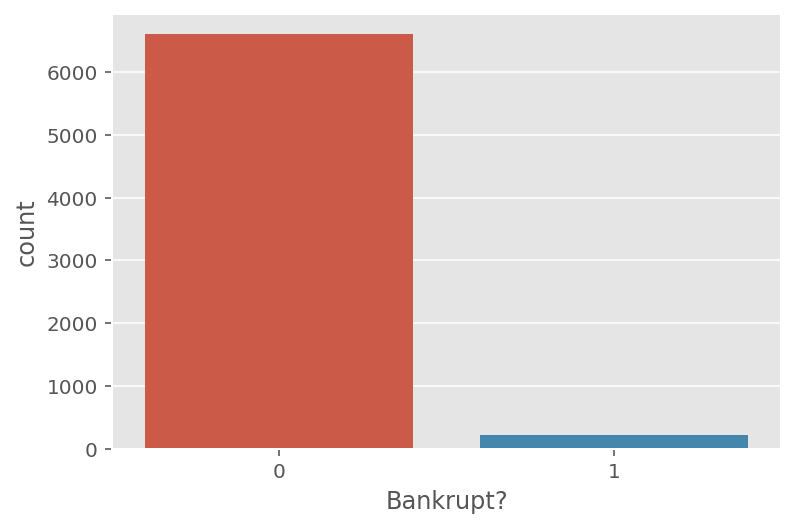

In [5]:
sns.countplot(df['Bankrupt?']);

* target 특성이 굉장히 imbalance 합니다. 후에 modeling 을 할때 SMOTE 로 조정해 주겠습니다.
* SMOTE 란 SMOTE의 동작 방식은 데이터의 개수가 적은 클래스의 표본을 가져온 뒤 임의의 값을 추가하여 새로운 샘플을 만들어 데이터에 추가하는 오버샘플링 방식입니다.
    * 오버샘플링은 정보가 손실되지 않는다는 장점이 있으나, 복제된 관측치를 원래 데이터 세트에 추가하기 만하면 여러 유형의 관측치를 다수 추가하여 오버 피팅 (overfitting)을 초래할 수 있습니다.
이러한 경우 trainset의 성능은 높으나 testset의 성능은 나빠질 수 있습니다.
하지만 test set의 성능이 나쁘지 않다면 오버피팅이 아니라고 반증할수 있습니다.

In [7]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

* 특성이 굉장히 많아서 이상치의 유무를 확인하기 어렵습니다. 몇가지 특성으로 확인해 보고 이상치를 제거하는 과정을 거치겠습니다.

In [8]:
df_corr = df.corr()
df_corr.sort_values(by='Bankrupt?', ascending=True)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
Net Income to Total Assets,-0.315457,0.887670,0.961552,0.912040,0.300143,0.298155,0.028482,0.048587,0.045390,0.028423,0.045600,0.071365,0.079169,0.281309,0.048735,0.231210,0.493776,0.493803,0.493822,0.691152,0.292252,-0.008315,0.577846,0.671748,0.003064,0.041046,0.119596,0.119870,0.024257,0.080031,-0.072408,0.062183,0.252716,0.014946,-0.017779,0.004969,-0.008056,-0.281422,0.281422,0.016566,...,0.133053,0.195652,-0.008154,-0.034389,-0.214085,0.341188,0.000992,0.003639,0.066277,0.123817,-0.150319,0.023702,0.794189,0.027065,-0.470498,-0.005032,-0.023834,0.005680,-0.016255,0.011634,-0.004380,0.066277,-0.150319,-0.120242,0.254898,0.142567,0.440095,0.120228,-0.202751,-0.169104,1.000000,-0.105201,0.011942,0.300146,0.328492,-0.159697,-0.010463,0.012746,NaN,0.073916
ROA(A) before interest and % after tax,-0.282941,0.940124,1.000000,0.955741,0.326969,0.324956,0.032053,0.053518,0.049474,0.029649,0.049909,0.075727,0.084334,0.288440,0.050362,0.225897,0.531799,0.531790,0.531821,0.764828,0.326239,-0.011829,0.654253,0.752578,0.003277,0.042208,0.125384,0.125872,0.024887,0.026977,-0.063970,0.081982,0.263615,0.014102,-0.018412,0.005440,-0.010323,-0.259972,0.259972,0.020707,...,0.157005,0.217918,-0.009612,-0.037468,-0.190501,0.351107,-0.000004,0.004864,0.080401,0.120403,-0.133816,0.022241,0.718013,0.028873,-0.357147,-0.000869,-0.025143,0.004491,-0.025817,0.012198,-0.005860,0.080401,-0.133816,-0.103015,0.263591,0.157065,0.443017,0.112929,-0.195673,-0.156890,0.961552,-0.098900,0.011463,0.326971,0.291744,-0.141039,-0.011515,0.013372,NaN,0.057887
ROA(B) before interest and depreciation after tax,-0.273051,0.986849,0.955741,1.000000,0.333749,0.331755,0.035212,0.053726,0.049952,0.022366,0.052261,0.065602,0.102147,0.323040,0.045839,0.197344,0.502052,0.502000,0.501907,0.764597,0.366216,-0.014359,0

### 이상치 제거 전 Boxplot
* 상관계수가 높은 6가지의 특징으로 시각화 했습니다.

[Text(0.5, 1.0, 'Bankrupt vs Debt ratio %')]

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


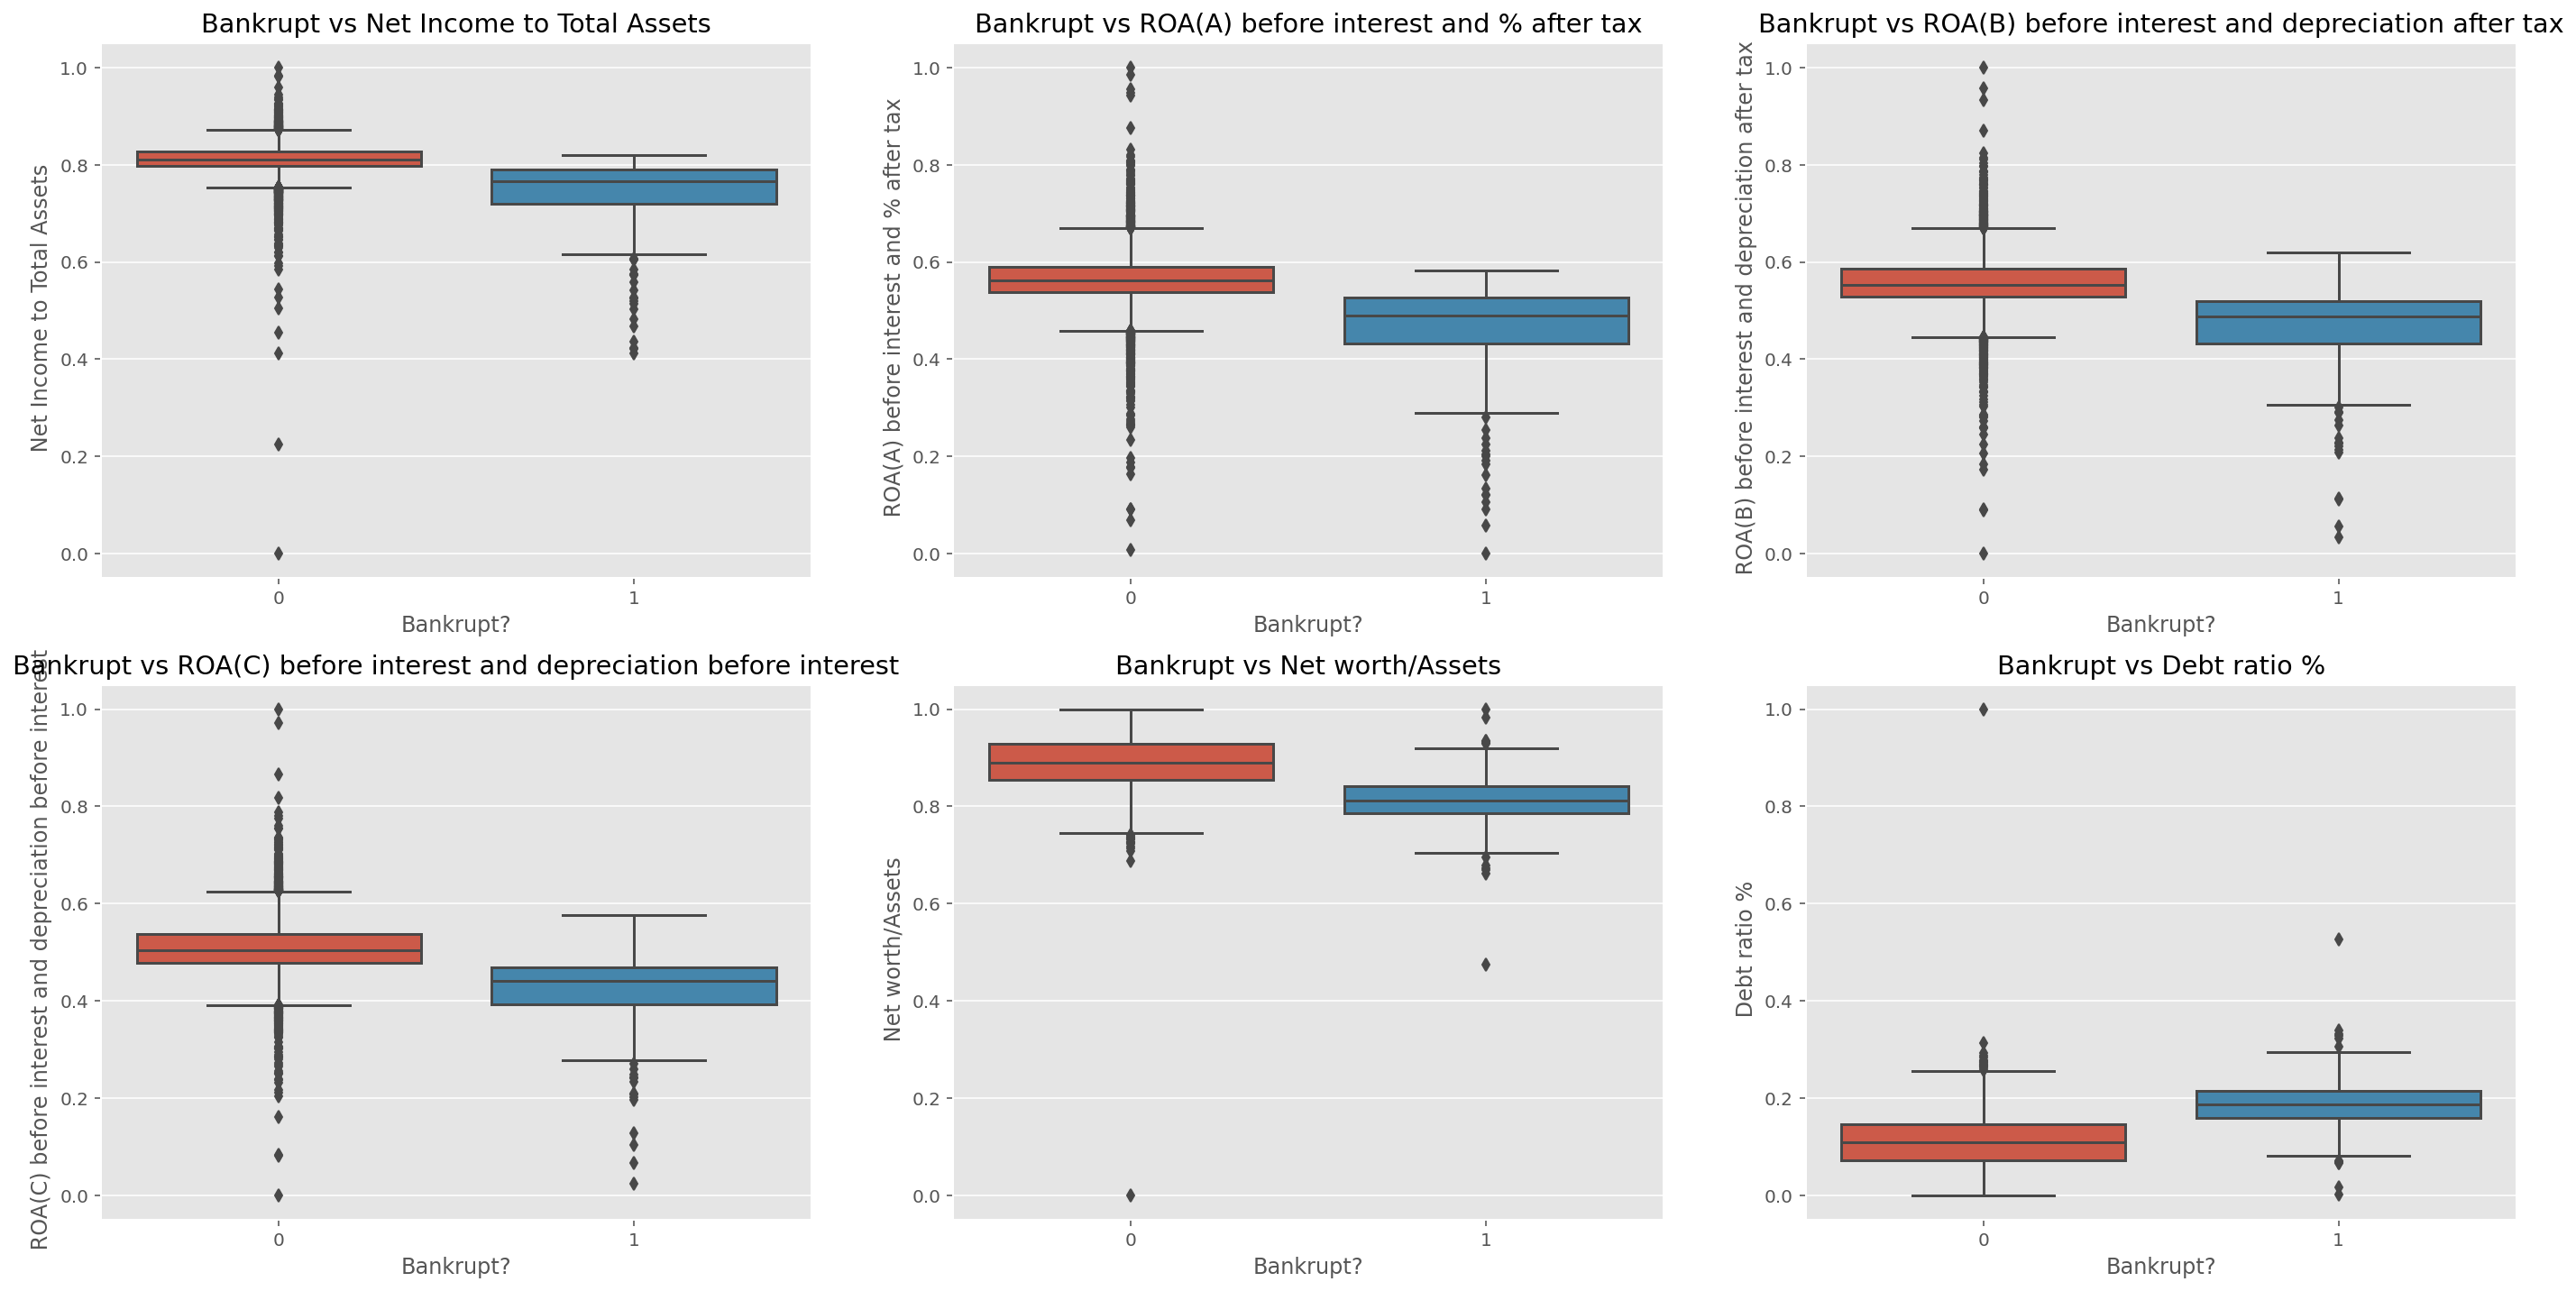

In [9]:
# boxplot 으로 몇가지 특성의 이상치 유무를 확인하겠습니다.

figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(24, 12)

sns.boxplot(data=df, x='Bankrupt?', y=' Net Income to Total Assets', ax=ax1)
sns.boxplot(data=df, x='Bankrupt?', y=' ROA(A) before interest and % after tax', ax=ax2)
sns.boxplot(data=df, x='Bankrupt?', y=' ROA(B) before interest and depreciation after tax', ax=ax3)
sns.boxplot(data=df, x='Bankrupt?', y=' ROA(C) before interest and depreciation before interest', ax=ax4)
sns.boxplot(data=df, x='Bankrupt?', y=' Net worth/Assets', ax=ax5)
sns.boxplot(data=df, x='Bankrupt?', y=' Debt ratio %', ax=ax6)

ax1.set(title='Bankrupt vs Net Income to Total Assets')
ax2.set(title='Bankrupt vs ROA(A) before interest and % after tax')
ax3.set(title='Bankrupt vs ROA(B) before interest and depreciation after tax')
ax4.set(title='Bankrupt vs ROA(C) before interest and depreciation before interest')
ax5.set(title='Bankrupt vs Net worth/Assets')
ax6.set(title='Bankrupt vs Debt ratio %')

* target 특성인 Bankrupt? 와 상관관계가 높은 6개의 특성을 가지고 boxplot 을 그려보니 굉장히 많은 이상치가 보였습니다.   
* 하지만 특성이 많은 데이터 이기 때문에 특성을 일부 선택을 해서 이상치를 제거 하고 모델을 만들어 보겠습니다.


### 특성이 95개 굉장히 많기 때문에 KBest Selection 을 이용하여 특성을 선택하겠습니다.

In [10]:
# Kbest Seletion 을 이용해서 특성을 선택해 주겠습니다.

target = 'Bankrupt?'

X = df.drop(target,axis=1)
y = df[target]

In [11]:
# K에 따른 f1_score 를 보겠습니다.

feature_com = []
for i in range(1, 96):
    # feature개수 적용
    selector = SelectKBest(score_func=f_classif, k=i)
    X_BEST = selector.fit_transform(X, y)

    # 오차값산출
    lr = LogisticRegression()
    lr.fit(X_BEST, y)
    y_pred = lr.predict(X_BEST)
    f1 = f1_score(y, y_pred)

    # 리스트에 저장
    feature_com.append([i, f1])

# in DataFrame
df_feature = pd.DataFrame(feature_com)
df_feature.columns = ['Num of K', 'f1 score']
df_feature.sort_values('f1 score', ascending=False).head()

,Num of K,f1 score
35,36,0.186770
34,35,0.186770
12,13,0.186770
22,23,0.180392
17,18,0.180392


* 36개의 특성을 선택했을때 f1_score가 가장 뛰어난것을 볼수있습니다. 이제 그 특성이 어떤것인지 확인해보겠습니다.

In [12]:
# 36개의 특성 확인

selector = SelectKBest(score_func=f_classif, k=36)
X_K = selector.fit_transform(X, y)

## 선택된 feature확인
all_names = X.columns 
selected_mask = selector.get_support()

selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %',
       ' Net worth/Assets', ' Borrowing dependency',
       ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital',
       ' Operating profit per person', ' Working Capital to Total Assets',
       ' Quick Assets/Total Assets', ' Cash/Total Assets',
       ' Current Liability to Assets', ' Working Capital/Equity',
       ' Current Liabilities/Equity', ' Retained Earnings to Total Assets',
       ' Total expense/Assets', ' Current 

* 36개의 특성은 위의 Selected names 변수에 들어가 있습니다. 

In [13]:
# df_new 로 세로운 data frame 을 만들어 주겠습니다.

df_new = df[selected_names]
df_new = pd.concat([df_new, y], axis=1)
print(df_new.shape)
df_new.head()

(6819, 37)


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Debt ratio %,Net worth/Assets,Borrowing dependency,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Operating profit per person,Working Capital to Total Assets,Quick Assets/Total Assets,Cash/Total Assets,Current Liability to Assets,Working Capital/Equity,Current Liabilities/Equity,Retained Earnings to Total Assets,Total expense/Assets,Current Liability to Equity,Equity to Long-term Liability,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.0,0.147950,0.147950,0.147950,0.169141,0.095921,0.138736,0.207576,0.792424,0.390284,0.095885,0.137757,0.392913,0.672775,0.166673,0.004094,0.147308,0.721275,0.339077,0.903225,0.064856,0.339077,0.126549,0.520382,0.118250,0,0.716845,0.601453,0.827890,0.290202,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.0,0.182251,0.182251,0.182251,0.208944,0.093722,0.169918,0.171176,0.828824,0.376760,0.093743,0.168962,0.391590,0.751111,0.127236,0.014948,0.056963,0.731975,0.329740,0.931065,0.025516,0.329740,0.120916,0.567101,0.047775,0,0.795297,0.610237,0.839969,0.283846,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.0,0.177911,0.177911,0.193713,0.180581,0.092338,0.142803,0.207516,0.792484,0.379093,0.092318,0.148036,0.381968,0.829502,0.340201,0.000991,0.098162,0.742729,0.334777,0.909903,0.021387,0.334777,0.117922,0.538491,0.025346,0,0.774670,0.601449,0.836774,0.290189,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.0,0.154187,0.154187,0.154187,0.193722,0.077762,0.148603,0.151465,0.848535,0.379743,0.077727,0.147561,0.378497,0.725754,0.161575,0.018851,0.098715,0.729825,0.331509,0.906902,0.024161,0.331509,0.120760,0.604105,0.067250,0,0.739555,0.583538,0.834697,0.281721,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.0,0.167502,0.167502,0.167502,0.212537,0.096898,0.168412,0.106509,0.893491,0.375025,0.096927,0.167461,0.394371,0.751822,0.260330,0.014161,0.110195,0.732000,0.330726,0.913850,0.026385,0.330726,0.110933,0.578469,0.047725,0,0.795016,0.598782,0.839973,0.278514,0.035490,1


* seleted 한 feature 를 가지고 df_new 라는 data set 을 새로 만들었습니다.

In [14]:
# 이상치를 제거하기 위한 함수를 만들겠습니다.

def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [15]:
out_idx =[]

for i in df_new.columns:    
    outlier_idx = get_outlier(df=df_new, column=i, weight=1.5)
    df_new.drop(outlier_idx, axis=0, inplace=True)
    out_idx.append([outlier_idx])

In [16]:
df_new.shape

(2552, 37)

### 이상치 제거 후 Boxplot

[Text(0.5, 1.0, 'Bankrupt vs Debt ratio %')]

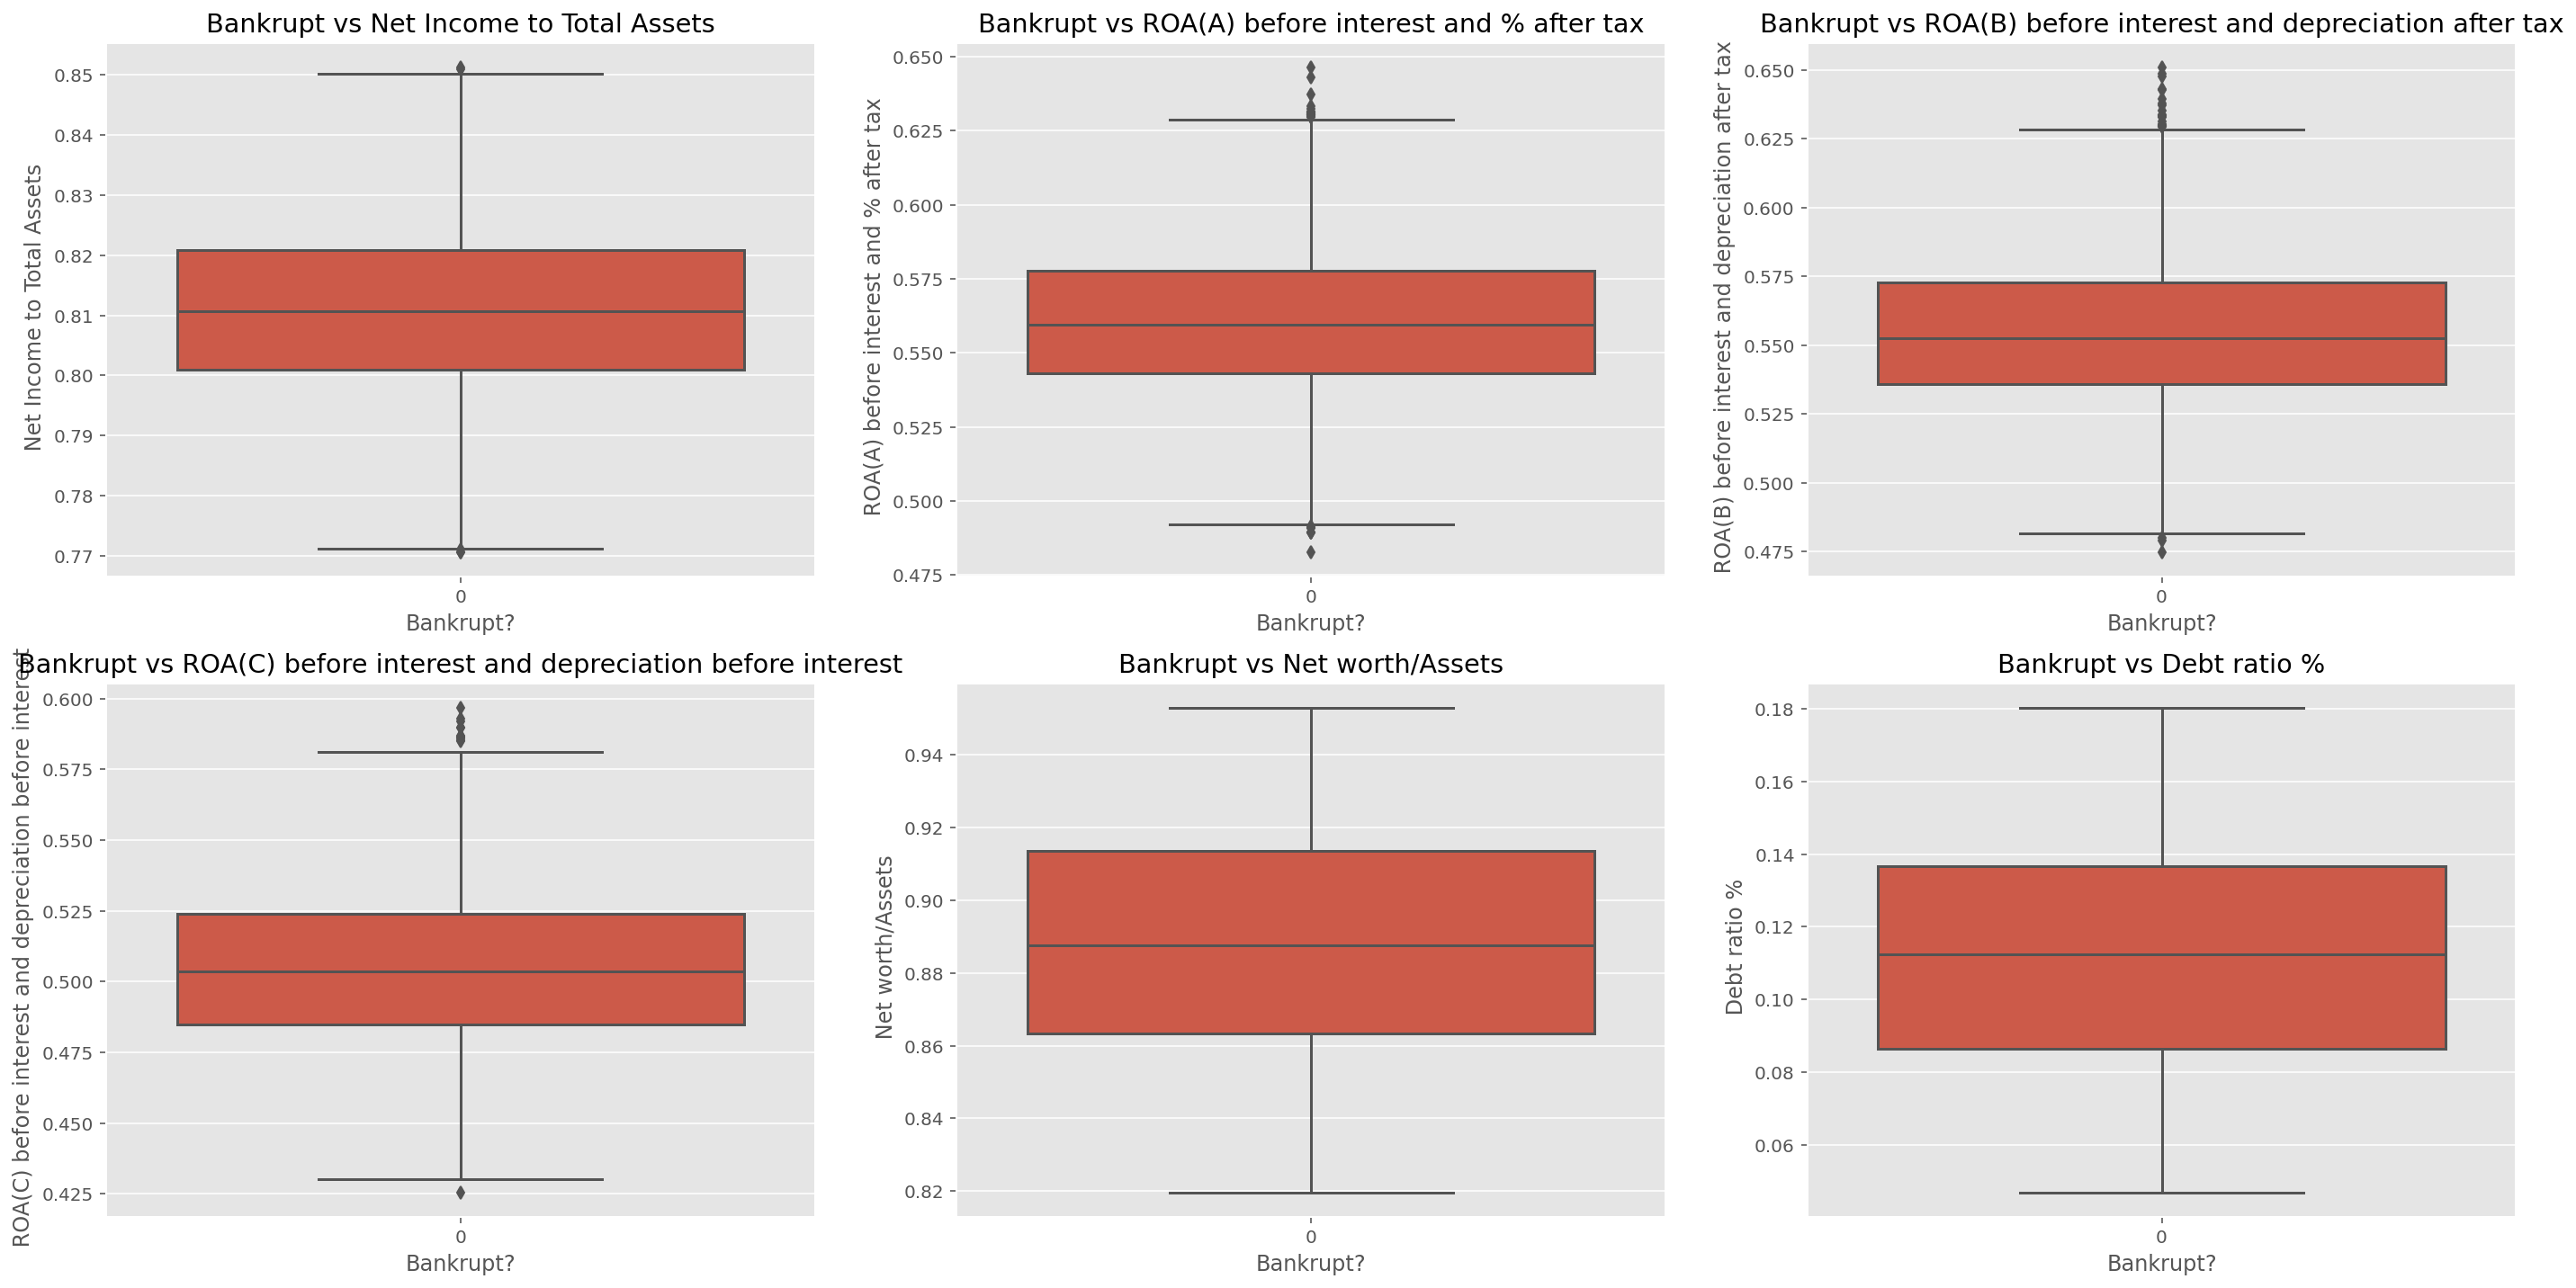

In [17]:
# 위에서 똑같은 특성을 가지고 boxplot 이상치 유무를 확인하겠습니다.

figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(24, 12)

sns.boxplot(data=df_new, x='Bankrupt?', y=' Net Income to Total Assets', ax=ax1)
sns.boxplot(data=df_new, x='Bankrupt?', y=' ROA(A) before interest and % after tax', ax=ax2)
sns.boxplot(data=df_new, x='Bankrupt?', y=' ROA(B) before interest and depreciation after tax', ax=ax3)
sns.boxplot(data=df_new, x='Bankrupt?', y=' ROA(C) before interest and depreciation before interest', ax=ax4)
sns.boxplot(data=df_new, x='Bankrupt?', y=' Net worth/Assets', ax=ax5)
sns.boxplot(data=df_new, x='Bankrupt?', y=' Debt ratio %', ax=ax6)

ax1.set(title='Bankrupt vs Net Income to Total Assets')
ax2.set(title='Bankrupt vs ROA(A) before interest and % after tax')
ax3.set(title='Bankrupt vs ROA(B) before interest and depreciation after tax')
ax4.set(title='Bankrupt vs ROA(C) before interest and depreciation before interest')
ax5.set(title='Bankrupt vs Net worth/Assets')
ax6.set(title='Bankrupt vs Debt ratio %')

* 각 데이터의 이상치가 많아 이상치를 제거를 하고 확인해보니 sample 수가 2550 여개로 굉장히 많이 줄어 들었고, target 특성인 Bankrupt? 의 파산 value 인 1값이 모두 제거가 되었습니다.  
* 여기서 저는 모델의 성능을 희생하더라도 이상치를 포함한 data set으로 예측을 해야함을 알았습니다.

# 모델링

In [18]:
target = 'Bankrupt?'

X = df.drop(target,axis=1)
y = df[target]

In [19]:
df_new = df[selected_names]
df_new = pd.concat([df_new, y], axis=1)
print(df_new.shape)

(6819, 37)


In [20]:
target = 'Bankrupt?'

X = df_new.drop(target,axis=1)
y = df_new[target]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4364, 36)
(4364,)
(1091, 36)
(1091,)
(1364, 36)
(1364,)


In [22]:
# RandomForestClassifier 

pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(class_weight='balanced')
)

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)
y_pred_test = pipe.predict(X_test)

print('훈련 f1 score: ', f1_score(y_pred_train, y_train))
print('검증 f1 score: ', f1_score(y_pred_val, y_val))
print('TEST f1 score: ', f1_score(y_pred_test, y_test))

훈련 f1 score:  1.0
검증 f1 score:  0.2222222222222222
TEST f1 score:  0.08888888888888889


In [23]:
# XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(), 
    XGBClassifier(class_weight='balanced')
)

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)
y_pred_test = pipe.predict(X_test)

print('훈련 f1 score: ', f1_score(y_pred_train, y_train))
print('검증 f1 score: ', f1_score(y_pred_val, y_val))
print('TEST f1 score: ', f1_score(y_pred_test, y_test))

훈련 f1 score:  0.6757990867579907
검증 f1 score:  0.32653061224489793
TEST f1 score:  0.09302325581395349


### LGBMClassifier 모델링


In [24]:
# LGBMClassifier

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMClassifier(class_weight='balanced')
)

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)
y_test_pred = pipe.predict(X_test)

print('훈련 f1 score: ', f1_score(y_train_pred, y_train))
print('검증 f1 score: ', f1_score(y_val_pred, y_val))
print('TEST f1 score: ', f1_score(y_test_pred, y_test))

훈련 f1 score:  0.9965397923875432
검증 f1 score:  0.5151515151515151
TEST f1 score:  0.2727272727272727


* 각 베이스라인을 잡고 각모델을 돌려본 결과 LGBM 이 가장 높은 score가 나왔으므로 LGBM 모델을 튜닝하겠습니다.

# 튜닝

### SMOTE 으로 imbalance 한 target 조정하기

In [25]:
labels_original = df_new['Bankrupt?']
bank_data = df_new.drop(['Bankrupt?'], axis = 1)

# Transforming the dataset

oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(bank_data, labels_original)
counter = Counter(y_smote)
print(counter)

# Splitting the data 

X_t_sm, X_test_sm, y_t_sm, y_test_sm = train_test_split(X_smote,y_smote,
                                               test_size = 0.1,
                                               stratify = y_smote,
                                               shuffle = True)

X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(X_t_sm,y_t_sm,
                                               test_size = 0.1,
                                               stratify = y_t_sm,
                                               shuffle = True)

Counter({1: 6599, 0: 6599})


In [26]:
# LGBMClassifier

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMClassifier(class_weight='balanced')
)

pipe.fit(X_train_sm, y_train_sm)

y_train_pred = pipe.predict(X_train_sm)
y_val_pred = pipe.predict(X_val_sm)
y_test_pred = pipe.predict(X_test_sm)

print('훈련 f1 score: ', f1_score(y_train_pred, y_train_sm))
print('검증 f1 score: ', f1_score(y_val_pred, y_val_sm))
print('TEST f1 score: ', f1_score(y_test_pred, y_test_sm))

훈련 f1 score:  0.9976668222118525
검증 f1 score:  0.969795918367347
TEST f1 score:  0.9850523168908819


In [27]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train_sm)
X_val_encoded = encoder.transform(X_val_sm)
X_test_encoded = encoder.transform(X_test_sm)

In [28]:
fit_params={'early_stopping_rounds': 150, 
            'eval_metric' : 'f1_score', 
            'eval_set' : [(X_train_encoded, y_train_sm),
                          (X_val_encoded, y_val_sm)],
            'verbose': 1000}

param_test ={'max_depth':[-1, -5, 10, 30, 50, 100, 150, 300, 500],
             'reg_alpha': [0, 1, 2, 5, 10, 50, 100, 200, 300],
             'reg_lambda': [0, 1, 5, 20, 50, 100, 200, 300]}

lgbm = LGBMClassifier(random_state=33, learning_rate=0.5, n_estimators=15000)


gs = RandomizedSearchCV(
    estimator=lgbm, 
    param_distributions=param_test, 
    n_iter=50,
    scoring='f1',
    cv=3,
    random_state=33,
    verbose=3)


gs.fit(X_train_encoded, y_train_sm, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] reg_lambda=300, reg_alpha=0, max_depth=10 .......................
Training until validation scores don't improve for 150 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1000]	valid_0's binary_logloss: 0.0374929	valid_1's binary_logloss: 0.0875445
Early stopping, best iteration is:
[1662]	valid_0's binary_logloss: 0.0340982	valid_1's binary_logloss: 0.0859415
[CV]  reg_lambda=300, reg_alpha=0, max_depth=10, score=0.970, total=  14.6s
[CV] reg_lambda=300, reg_alpha=0, max_depth=10 .......................
Training until validation scores don't improve for 150 rounds.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s


[1000]	valid_0's binary_logloss: 0.0343017	valid_1's binary_logloss: 0.0909628
Early stopping, best iteration is:
[1381]	valid_0's binary_logloss: 0.0317041	valid_1's binary_logloss: 0.0902184
[CV]  reg_lambda=300, reg_alpha=0, max_depth=10, score=0.976, total=  12.1s
[CV] reg_lambda=300, reg_alpha=0, max_depth=10 .......................
Training until validation scores don't improve for 150 rounds.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.7s remaining:    0.0s


[1000]	valid_0's binary_logloss: 0.0320151	valid_1's binary_logloss: 0.0938402
Early stopping, best iteration is:
[1490]	valid_0's binary_logloss: 0.0287964	valid_1's binary_logloss: 0.0929796
[CV]  reg_lambda=300, reg_alpha=0, max_depth=10, score=0.975, total=  14.0s
[CV] reg_lambda=5, reg_alpha=50, max_depth=100 .......................
Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.218635	valid_1's binary_logloss: 0.242974
[CV]  reg_lambda=5, reg_alpha=50, max_depth=100, score=0.909, total=   0.5s
[CV] reg_lambda=5, reg_alpha=50, max_depth=100 .......................
Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.223217	valid_1's binary_logloss: 0.239041
[CV]  reg_lambda=5, reg_alpha=50, max_depth=100, score=0.909, total=   0.5s
[CV] reg_lambda=5, reg_alpha=50, max_depth=100 .......................
Training until valid

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.0min finished


Early stopping, best iteration is:
[723]	valid_0's binary_logloss: 0.00407706	valid_1's binary_logloss: 0.069821


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.5, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=15000, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=33, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_for_bin

In [29]:
print('검증 정확도', gs.score(X_val_encoded, y_val_sm))
print(classification_report(y_val_sm, gs.predict(X_val_encoded)))

검증 정확도 0.9785478547854785
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       594
           1       0.96      1.00      0.98       594

    accuracy                           0.98      1188
   macro avg       0.98      0.98      0.98      1188
weighted avg       0.98      0.98      0.98      1188



In [30]:
gs.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=150,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=15000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=33, reg_alpha=0, reg_lambda=100, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
gs.best_score_

0.9739618471148345

In [32]:
print(gs.best_params_)

{'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 150}


In [33]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train_sm)
X_val_encoded = encoder.transform(X_val_sm)
X_test_encoded = encoder.transform(X_test_sm)

In [34]:
lightGB = LGBMClassifier(learning_rate=0.01, max_depth=150, n_estimators=300000, num_leaves=31,
                      random_state=33, reg_alpha=0, reg_lambda=100, subsample=1.0)

eval_set = [(X_train_encoded, y_train_sm),
            (X_val_encoded,y_val_sm), 
            (X_test_encoded, y_test_sm)]

lightGB.fit(X_train_encoded, y_train_sm, 
          eval_set=eval_set,
          early_stopping_rounds=1000,
          eval_metric='f1_score',
          verbose=100
         )

Training until validation scores don't improve for 1000 rounds.
[100]	training's binary_logloss: 0.391427	valid_1's binary_logloss: 0.401494	valid_2's binary_logloss: 0.382146
[200]	training's binary_logloss: 0.282831	valid_1's binary_logloss: 0.30017	valid_2's binary_logloss: 0.27003
[300]	training's binary_logloss: 0.230765	valid_1's binary_logloss: 0.252052	valid_2's binary_logloss: 0.217602
[400]	training's binary_logloss: 0.202004	valid_1's binary_logloss: 0.226565	valid_2's binary_logloss: 0.190195
[500]	training's binary_logloss: 0.181738	valid_1's binary_logloss: 0.209076	valid_2's binary_logloss: 0.17167
[600]	training's binary_logloss: 0.166671	valid_1's binary_logloss: 0.196186	valid_2's binary_logloss: 0.158228
[700]	training's binary_logloss: 0.154648	valid_1's binary_logloss: 0.186141	valid_2's binary_logloss: 0.14831
[800]	training's binary_logloss: 0.144699	valid_1's binary_logloss: 0.177619	valid_2's binary_logloss: 0.140288
[900]	training's binary_logloss: 0.136158	va

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=150,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=33, reg_alpha=0, reg_lambda=100, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
y_train_pred = lightGB.predict(X_train_encoded)
y_val_pred = lightGB.predict(X_val_encoded)
y_test_pred = lightGB.predict(X_test_encoded)

In [36]:
len(y_test_pred),len(y_test)

(1320, 1364)

### 튜닝을 마치고 난 후 LGBM 모델 성능

In [37]:
print('훈련 f1 score: ', f1_score(y_train_sm, y_train_pred))
print('검증 f1 score: ', f1_score(y_val_sm, y_val_pred))
print('TEST f1 score: ', f1_score(y_test_sm, y_test_pred))

훈련 f1 score:  1.0
검증 f1 score:  0.9761316872427984
TEST f1 score:  0.9835575485799701


In [87]:
# permutation

permuter = PermutationImportance(lightGB,
                                 n_iter=5,
                                 random_state=1
)

permuter.fit(X_val_encoded.iloc[:100], y_val.iloc[:100]);

feature_names = feature_name
pd.Series(permuter.feature_importances_, feature_names).sort_values()

 Equity to Long-term Liability                             -0.060
 Borrowing dependency                                      -0.058
 Retained Earnings to Total Assets                         -0.046
 Current Liabilities/Equity                                -0.014
 Total expense/Assets                                      -0.012
 Persistent EPS in the Last Four Seasons                   -0.010
 Net Value Per Share (B)                                   -0.010
 Net Value Per Share (C)                                   -0.010
 Current Liability to Current Assets                       -0.008
 Net Income to Total Assets                                -0.006
 Liability to Equity                                       -0.006
 Tax rate (A)                                              -0.004
 Operating Profit Per Share (Yuan ¥)                       -0.004
 Current Liability to Assets                               -0.004
 Equity to Liability                                       -0.002
 Working C

In [88]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0020 ± 0.0080,CFO to Assets
0.0000 ± 0.0126,Operating profit per person
0 ± 0.0000,Net profit before tax/Paid-in capital
0.0000 ± 0.0126,ROA(A) before interest and % after tax
0 ± 0.0000,ROA(B) before interest and depreciation after tax
0 ± 0.0000,Operating Gross Margin
0 ± 0.0000,Realized Sales Gross Margin
0 ± 0.0000,Per Share Net profit before tax (Yuan ¥)
0 ± 0.0000,Debt ratio %
0 ± 0.0000,Net worth/Assets


In [89]:
pd.Series(permuter.feature_importances_, X_test.columns).sort_values()

 Equity to Long-term Liability                             -0.060
 Borrowing dependency                                      -0.058
 Retained Earnings to Total Assets                         -0.046
 Current Liabilities/Equity                                -0.014
 Total expense/Assets                                      -0.012
 Persistent EPS in the Last Four Seasons                   -0.010
 Net Value Per Share (B)                                   -0.010
 Net Value Per Share (C)                                   -0.010
 Current Liability to Current Assets                       -0.008
 Net Income to Total Assets                                -0.006
 Liability to Equity                                       -0.006
 Tax rate (A)                                              -0.004
 Operating Profit Per Share (Yuan ¥)                       -0.004
 Current Liability to Assets                               -0.004
 Equity to Liability                                       -0.002
 Working C

### 특성 중요도 확인

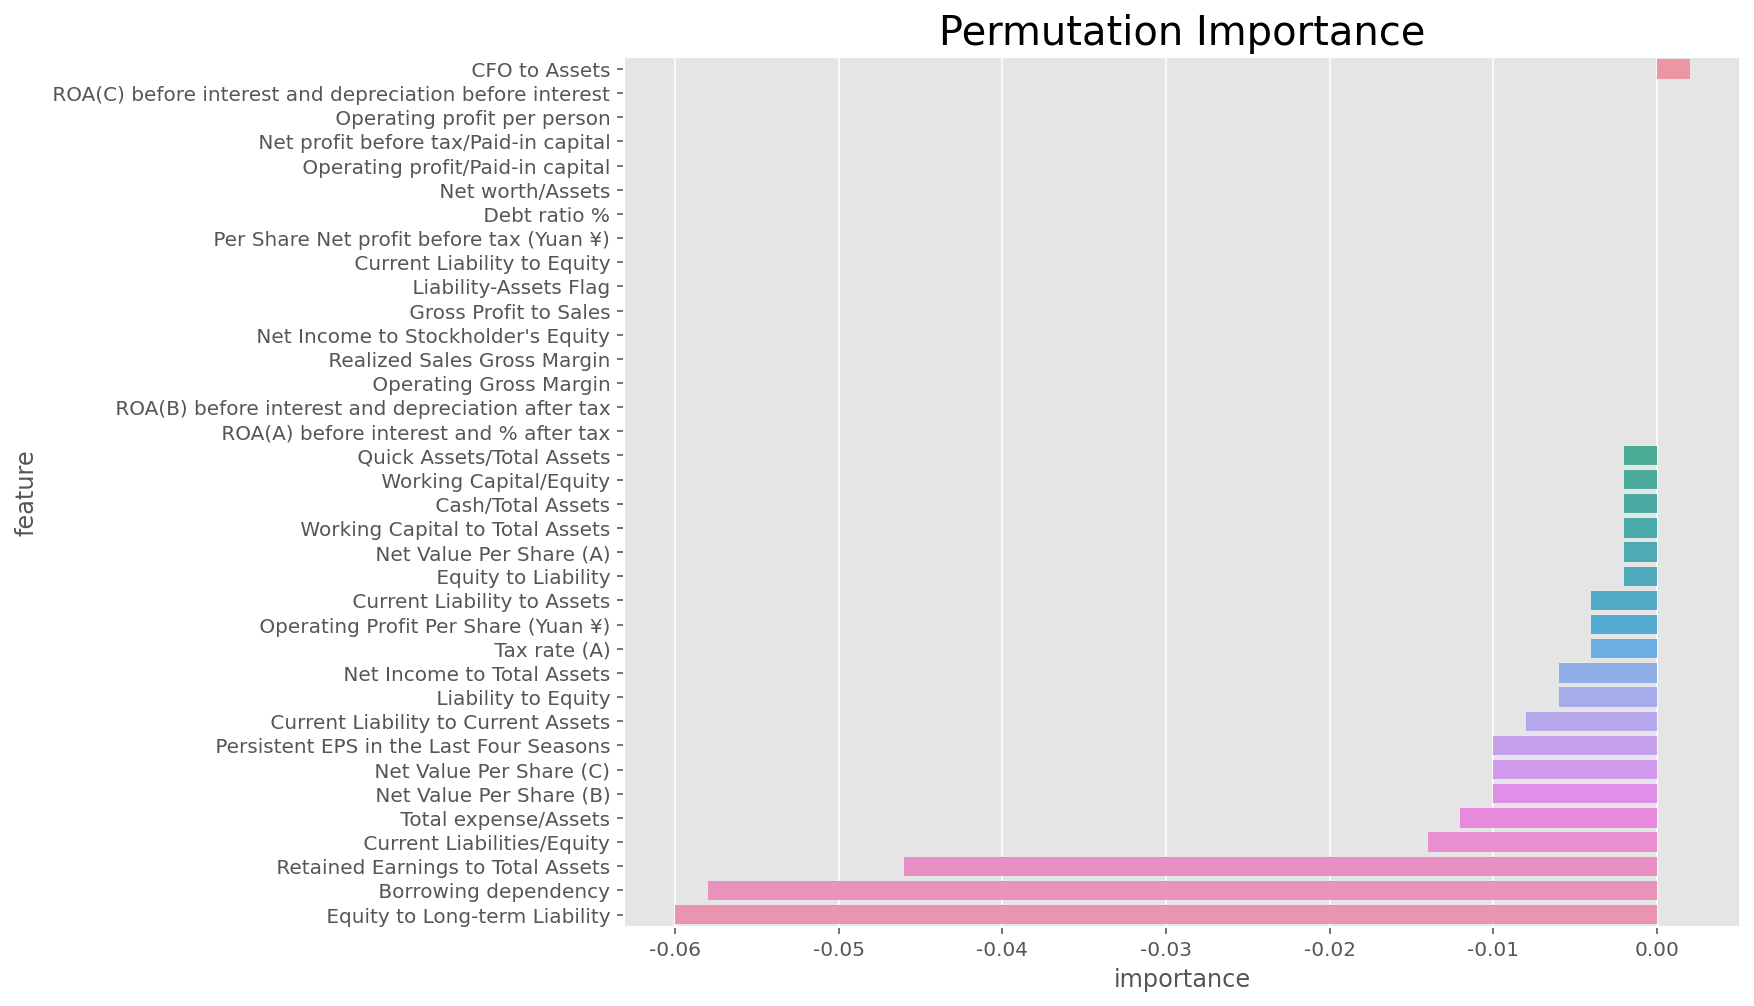

In [93]:
zipp  = []
for zipper in zip(X_train.columns, permuter.feature_importances_):
  zipp.append(zipper)
zipp = pd.DataFrame(zipp,columns=['feature','importance']).sort_values('importance',ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(y = zipp.feature, x= zipp.importance)
plt.title("Permutation Importance",fontsize=20);

* CFO to Assets 의 특성이 가장 중요하다고 나왔습니다.

In [50]:
feature_name = [' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %',
       ' Net worth/Assets', ' Borrowing dependency',
       ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital',
       ' Operating profit per person', ' Working Capital to Total Assets',
       ' Quick Assets/Total Assets', ' Cash/Total Assets',
       ' Current Liability to Assets', ' Working Capital/Equity',
       ' Current Liabilities/Equity', ' Retained Earnings to Total Assets',
       ' Total expense/Assets', ' Current Liability to Equity',
       ' Equity to Long-term Liability', ' CFO to Assets',
       ' Current Liability to Current Assets', ' Liability-Assets Flag',
       ' Net Income to Total Assets', ' Gross Profit to Sales',
       " Net Income to Stockholder's Equity", ' Liability to Equity',
       ' Equity to Liability']

In [82]:
# pdp

X_test_encoded.columns = X_test.columns

In [83]:
X_test_encoded

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Debt ratio %,Net worth/Assets,Borrowing dependency,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Operating profit per person,Working Capital to Total Assets,Quick Assets/Total Assets,Cash/Total Assets,Current Liability to Assets,Working Capital/Equity,Current Liabilities/Equity,Retained Earnings to Total Assets,Total expense/Assets,Current Liability to Equity,Equity to Long-term Liability,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Equity to Liability
0,0.385244,0.459441,0.448260,0.598826,0.598826,0.000000,0.166259,0.166259,0.166259,0.163280,0.079156,0.118945,0.214476,0.785524,0.389959,0.079137,0.117918,0.374735,0.767559,0.672690,0.055038,0.222896,0.734447,0.347298,0.914952,0.068438,0.347298,0.111007,0.495498,0.044545,0.0,0.745279,0.598822,0.831610,0.292034,0.015810
1,0.532199,0.574357,0.579795,0.617550,0.617550,0.234133,0.207787,0.207787,0.207787,0.257918,0.132888,0.202832,0.189407,0.810593,0.387649,0.132460,0.201561,0.406085,0.789868,0.502990,0.056022,0.120446,0.736404,0.334960,0.944479,0.013573,0.334960,0.131534,0.451276,0.035359,0.0,0.815686,0.617547,0.842565,0.286495,0.018425
2,0.560035,0.582861,0.606403,0.611186,0.611186,0.000000,0.158780,0.158780,0.158780,0.223693,0.100888,0.177299,0.093479,0.906521,0.369845,0.100901,0.176314,0.393162,0.851104,0.583977,0.288650,0.099647,0.738001,0.330028,0.911170,0.055546,0.330028,0.110933,0.684911,0.022590,0.0,0.822625,0.611185,0.841851,0.277848,0.040805
3,0.342887,0.138065,0.368215,0.563477,0.563477,0.000000,0.100410,0.100410,0.100410,0.146346,0.081657,0.069491,0.408589,0.591411,0.310374,0.081672,0.071301,0.371183,0.584954,0.249066,0.063903,0.272823,0.788813,0.275681,0.793560,0.201081,0.275681,0.102741,0.627750,0.202603,1.0,0.454445,0.563475,0.941424,0.229061,0.006848
4,0.506069,0.562745,0.559827,0.600722,0.600722,0.101528,0.178332,0.178332,0.178332,0.228326,0.108216,0.182044,0.178976,0.821024,0.379261,0.108188,0.181110,0.397040,0.753047,0.206635,0.056610,0.094611,0.732181,0.332474,0.936829,0.012408,0.332474,0.130133,0.633787,0.046947,0.0,0.810491,0.600718,0.841737,0.284880,0.019723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.447504,0.494972,0.494564,0.606174,0.606126,0.000000,0.147946,0.147946,0.147946,0.201228,0.088984,0.160476,0.197300,0.802700,0.382713,0.088955,0.159510,0.389862,0.706190,0.292053,0.059444,0.176912,0.726472,0.340084,0.899465,0.059686,0.340084,0.118099,0.595339,0.067437,0.0,0.768673,0.606175,0.836280,0.287943,0.017533
1316,0.433614,0.475976,0.471741,0.592249,0.592249,0.000000,0.149910,0.149910,0.149910,0.174189,0.080355,0.138332,0.211506,0.788494,0.384066,0.082216,0.141596,0.367079,0.687897,0.427614,0.004968,0.208666,0.722849,0.345333,0.907214,0.044316,0.345333,0.113595,0.526148,0.073619,0.0,0.722095,0.592249,0.828080,0.291228,0.016092
1317,0.490469,0.566943,0.547031,0.638615,0.638803,0.000000,0.171716,0.171716,0.171716,0.220100,0.097630,0.175567,0.017414,0.982586,0.369637,0.097603,0.174632,0.393128,0.939723,0.697372,0.455234,0.020016,0.740258,0.326739,0.938677,0.056122,0.326739,0.110933,0.801178,0.003985,0.0,0.817241,0.638614,0.841094,0.275196,0.198208
1318,0.492468,0.560456,0.543766,0.600052,0.600052,0.120559,0.233239,0.233239,0.233239,0.233526,0.108297,0.187844,0.117242,0.882758,0.371385,0.108294,0.186758,0.399166,0.828605,0.402135,0.027401,0.123131,0.737262,0.331563,0.936565,0.018148,0.331563,0.110933,0.5431

### Retained Earnings to Total Assset 으로 PDP 확인
* Retained Earnings to Total Assset 은 회사의 총 자산에 대한 누적 수입 비율입니다.

In [84]:
# 파산 1위

isolated = pdp_isolate(
    model=lightGB, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=' Retained Earnings to Total Assets',
    grid_type='percentile'
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


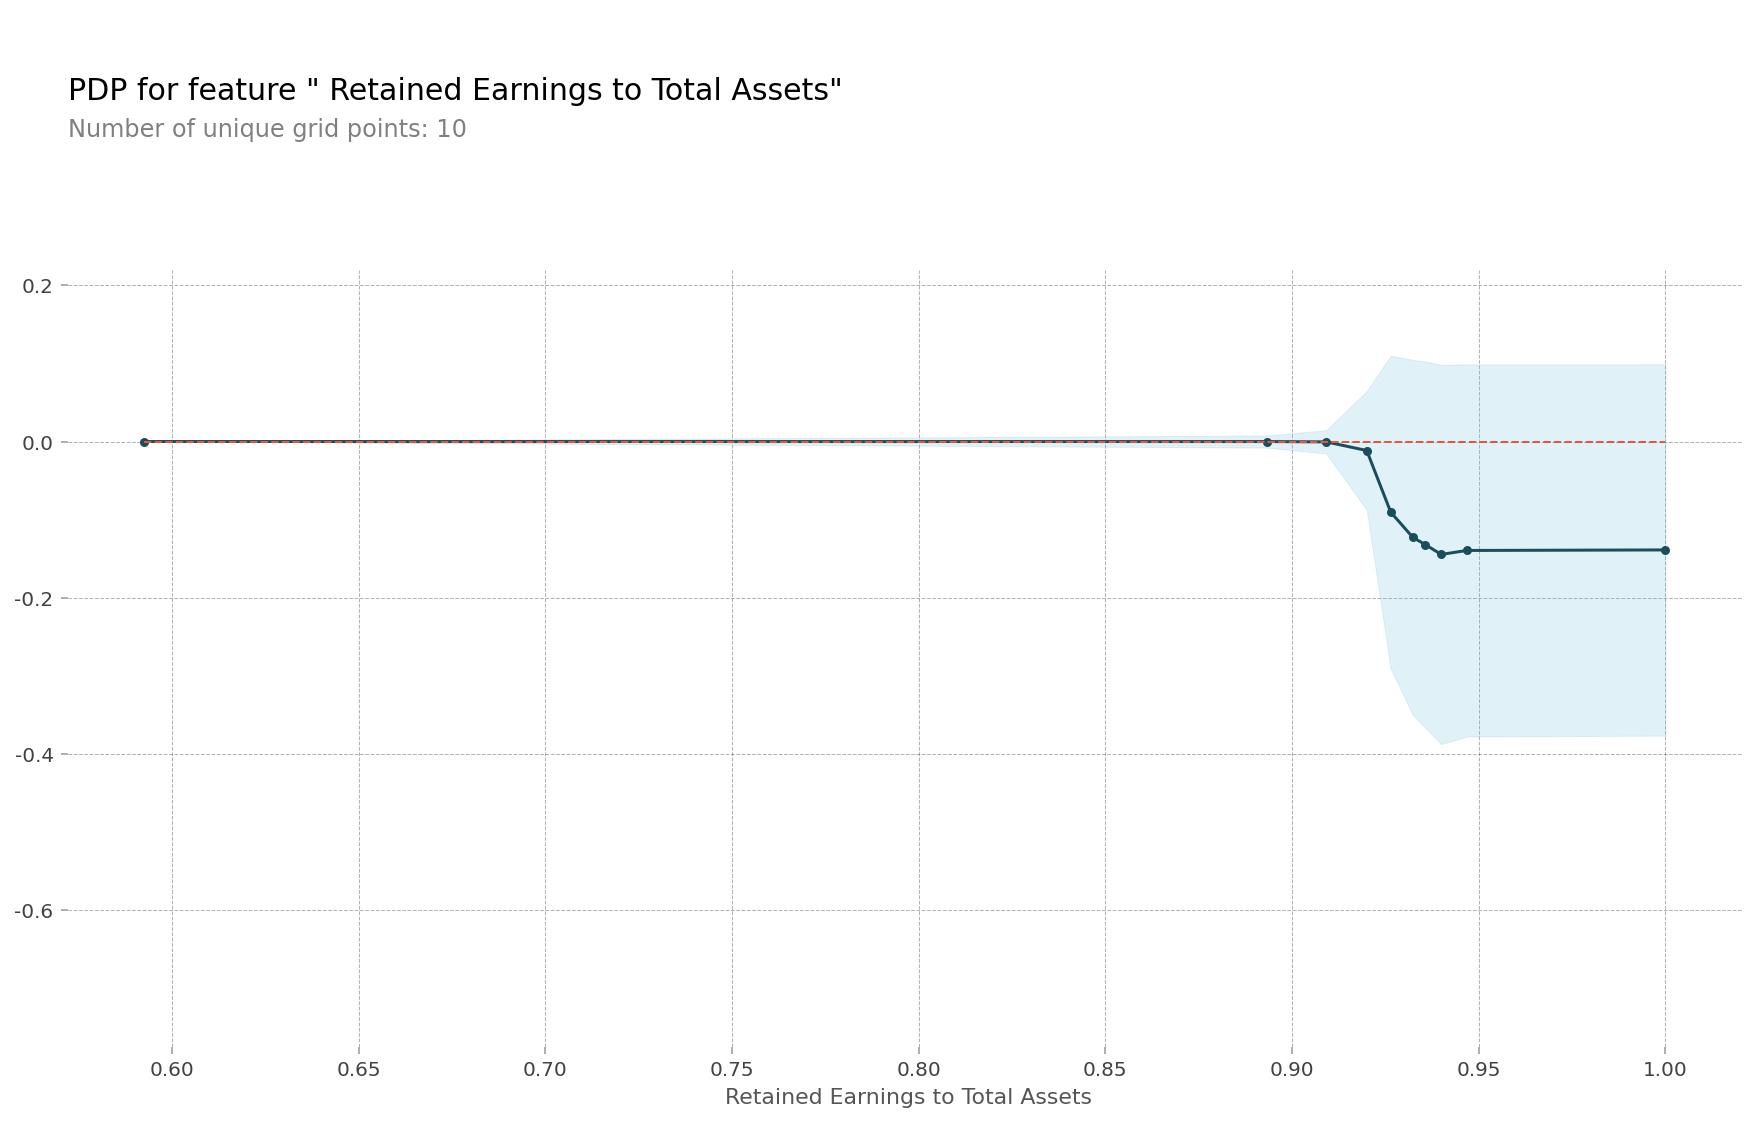

In [85]:
pdp_plot(isolated, feature_name=' Retained Earnings to Total Assets');

### CFO to Assets 으로 PDP 확인
* CFO to Assets 는 총 자산의 현금 흐름은 소득 인식이나 소득 측정에 영향을받지 않고 회사 자산에 현금 흐름을 평가하는 효율성 비율입니다. 이 비율은 운영의 현금 흐름을 평균 총 자산으로 나누어 계산합니다.


In [94]:
# CFO pdp

isolated = pdp_isolate(
    model=lightGB, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=' CFO to Assets',
    grid_type='percentile'
)

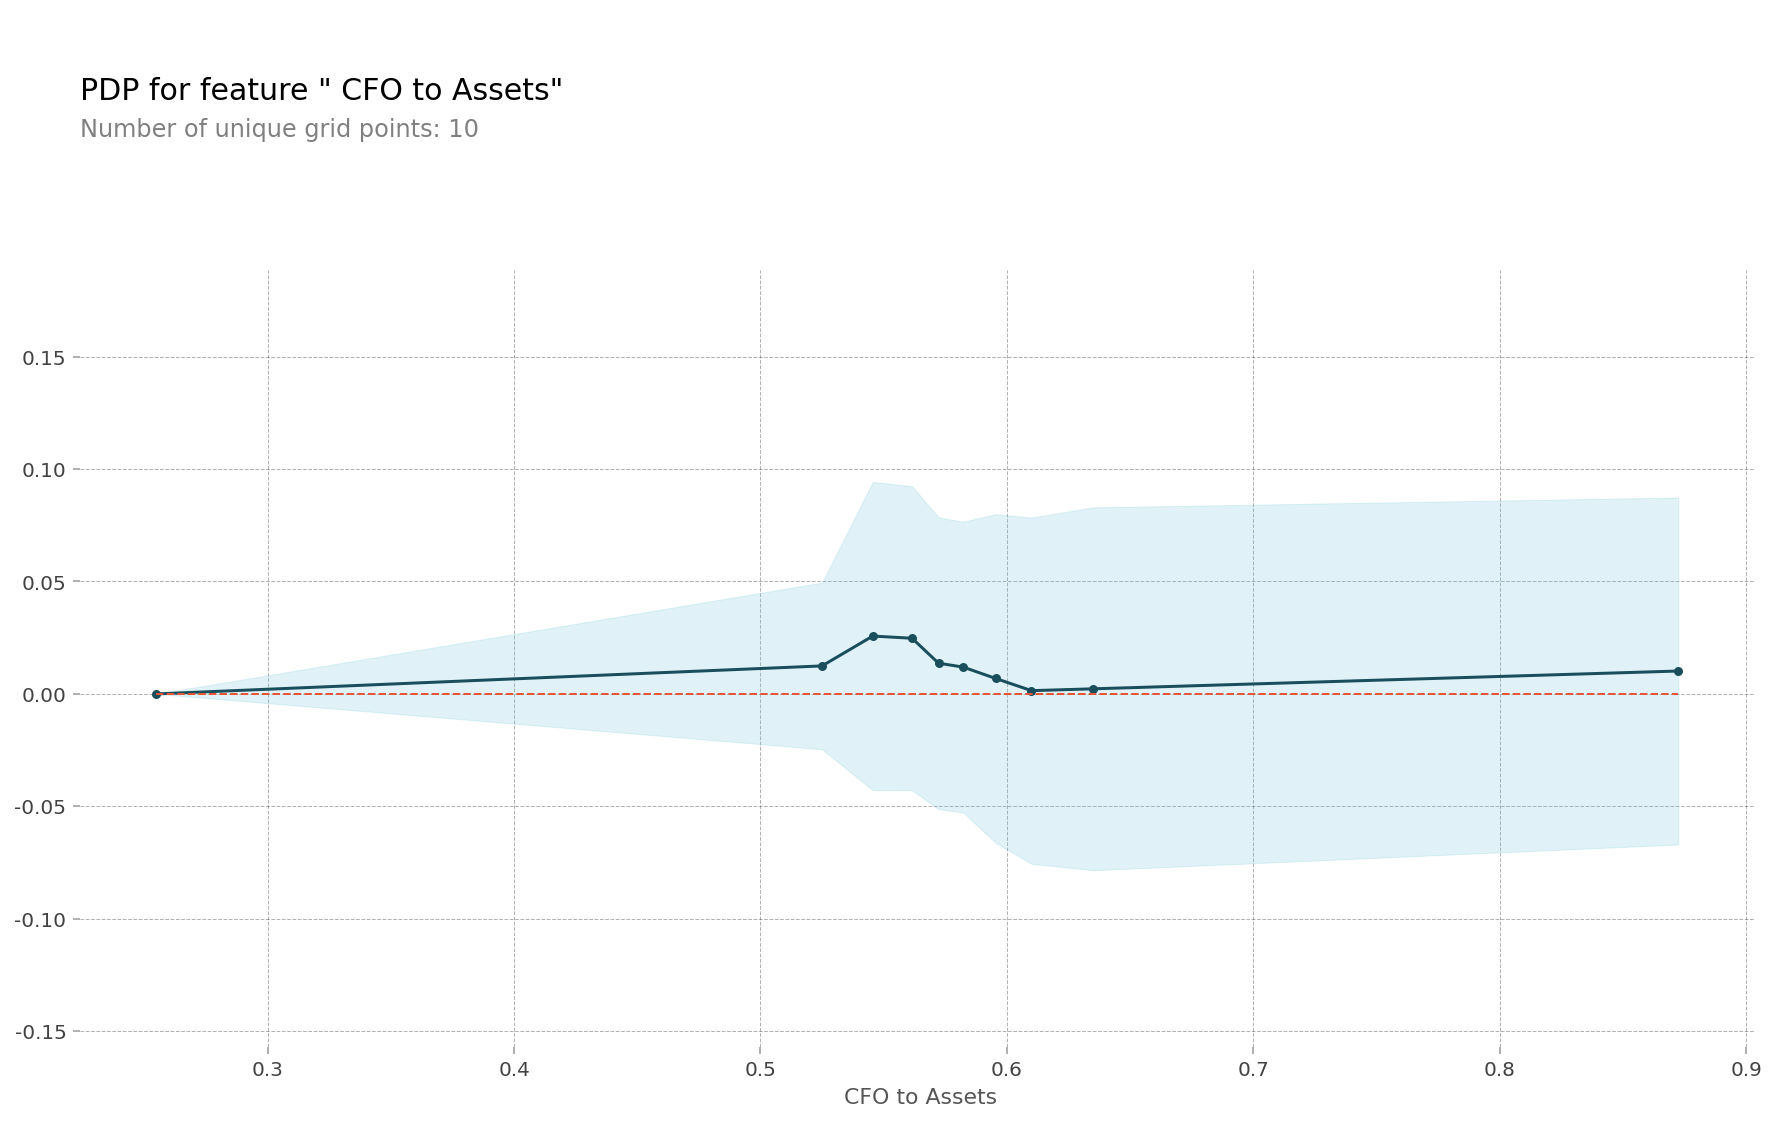

In [95]:
pdp_plot(isolated, feature_name=' CFO to Assets');

* 0.5에서 약간 튀긴 했지만 별의미 없어보입니다.

In [96]:
# shap

explainer = shap.TreeExplainer(lightGB)

In [97]:
sample1 = X_test_encoded.iloc[[300]]
sample2 = X_test_encoded.iloc[[600]]
sample3 = X_test_encoded.iloc[[900]]

In [98]:
shap_values1 = explainer.shap_values(sample1)
shap_values2 = explainer.shap_values(sample2)
shap_values3 = explainer.shap_values(sample3)

In [99]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values1[1], 
                feature_name,
                link='logit'
                )

In [100]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values2[1], 
                feature_name,
                link='logit')

### 100% 확률로 파산을 하게될 feature를 shap으로 확인

In [101]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values3[1], 
                feature_name,
                link='logit')

* shap를 확인해봤습니다. 특성이 0.9 가 넘어야지 파산할 확률이 줄어드는데 0.9란 수치는 굉장히 어려운 수치입니다. 하지만 가장큰 영향을 미치므로 100%의 확률로 파산을 하게될 것입니다.

* 이렇게 서로 다른 특성들로 인해 파산을 하게된다는걸 알게되었습니다.
* 따라서 한두가지 특성을 가지고 판단하면 안되고, 기업의 총체적인 재무수치를 가지고 면밀히 분석을 해야 할것같습니다.